<img src="assets/logo.png" width="300px">

# Supplementary 3 - Final Model Training and Export
**BoutScout: A Deep Learning Framework for Automatic Detection of Incubation Events in Avian Nests Using Temperature Time Series**

Author: [Jorge Lizarazo](https://www.researchgate.net/profile/Jorge-Lizarazo-Borrero?ev=hdr_xprf)

This notebook describes the training of the final production-ready BiLSTM model using the complete cleaned dataset (2,232 nest-days). We apply class-balanced weights to address label imbalance and track training loss over 80 epochs. The trained model is saved in both PyTorch (`.pth`) and ONNX formats, enabling deployment in diverse environments. Additionally, we extract hidden representations from the LSTM layers and visualize them using t-SNE, providing insight into class separation in latent space. This version of the model is designed to support fast and reproducible inference across a variety of applications.


**Year:** 2025

In [2]:
import numpy as np
import glob
import os
import pandas as pd
import json
import ast
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
import torch.optim as optim
from scipy.interpolate import interp1d
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

In [3]:
# Kargar arrays
X_array = np.load("X_array_cleaned.npy", allow_pickle=True)
y_array = np.load("y_array_cleaned.npy", allow_pickle=True)

# Kargar clases del LabelEncoder
le = LabelEncoder()
le.classes_ = np.load("label_classes.npy", allow_pickle=True)

# Definir Dataset
class NestEventDataset(Dataset):
    def __init__(self, X_array, y_array):
        self.X_array = X_array
        self.y_array = y_array

    def __len__(self):
        return len(self.X_array)

    def __getitem__(self, idx):
        X = self.X_array[idx].astype(np.float32)
        y = self.y_array[idx].astype(np.int64)
        return torch.tensor(X), torch.tensor(y)

# Crear el dataset
dataset = NestEventDataset(X_array, y_array)

In [4]:
idx = random.randint(0, len(dataset) - 1)
X_sample, y_sample = dataset[idx]
X_np = X_sample.numpy()
y_np = y_sample.numpy()

In [5]:
print(f"Numero total de dias (entradas): {len(y_array)}")

Numero total de dias (entradas): 2232


In [6]:
idx = random.randint(0, len(X_array) - 1)
X_sample = X_array[idx].astype(np.float32)
y_sample = y_array[idx].astype(np.int64)

X_np = X_sample
y_np = y_sample

In [7]:
y_np

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [8]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out)
        return out

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



We create folders to store the trained model, weight matrices, and t-SNE results. Also initialized the final DataLoader using the full dataset for training.

In [10]:
# Crear carpeta si no existe
os.makedirs("modelo_fi_total", exist_ok=True)
os.makedirs("modelo_fi_total/weights", exist_ok=True)
os.makedirs("modelo_fi_total/tsne", exist_ok=True)

In [11]:
final_dataset = NestEventDataset(X_array, y_array)
final_loader = DataLoader(final_dataset, batch_size=16, shuffle=True)

In [12]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.manifold import TSNE

## Final model setup with class-weighted loss
We define the final BiLSTM model and apply class weighting to address label imbalance.
Weights are automatically computed and manually adjusted to penalize misclassification of `Off` and `On` bouts more heavily. The weighted loss function helps the model learn from underrepresented transitions, improving overall class balance during training.

In [14]:
modelo_final = BiLSTMModel(
    input_size=X_array[0].shape[1],
    hidden_size=64,
    num_layers=2,
    num_classes=3
).to(device)

optimizer = optim.Adam(modelo_final.parameters(), lr=0.001)
y_array_flat = np.concatenate(y_array).ravel()

# Kalklar pesos balansiados otomatikos
class_weights = compute_class_weight('balanced', classes=np.unique(y_array_flat), y=y_array_flat)

#
class_weights[1] *= 2.5  # kastigo adisional a Off
class_weights[2] *= 3.0  # kastigo mas fuerte a On

# Trokar a tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# verifikar
print("Pesos finales usados para la pérdida:", class_weights)

# Funsion de perdida ponderada
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
num_epochs = 80

modelo_final.train()
losses = []


Pesos finales usados para la pérdida: [0.67203107 4.40714054 3.17556986]


# Final model training, export, and latent space analysis
We train the final version of the BiLSTM model for 80 epochs using the full dataset, applying the class-weighted loss function to improve sensitivity to `Off` and `On` transitions. Training loss is recorded at each epoch to monitor convergence.

After training, we:
1. Save the final model weights in PyTorch format (`.pth`).
2. Export the loss curve as a NumPy array for later visualization.
3. Extract and save learned weight matrices from each LSTM layer.
4. Export the model in ONNX format for deployment in non-PyTorch environments.

To explore how the model organizes behavior patterns internally, there was extracted the average hidden representation per sequence and apply t-SNE dimensionality reduction, and yet it was not taken into consideration for the manuscript. This allows us to visualize the latent structure of the learned embedding space and assess class separation. All results are saved in the `modelo_fi_total/` folder.

In [15]:
for epoch in range(num_epochs):
    running_loss = 0.0
    for X_batch, y_batch in final_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = modelo_final(X_batch)
        loss = criterion(outputs.view(-1, outputs.shape[-1]), y_batch.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(final_loader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")

# === Asentar rezultados ===

# 1. modelo ambezado
torch.save(modelo_final.state_dict(), "modelo_fi_total/modelo_entrenado_final_total.pth")

# 2. kurva de desaparesimiento
np.save("modelo_fi_total/training_loss.npy", np.array(losses))

# 3. pesos por estrato
for name, param in modelo_final.named_parameters():
    if "weight" in name:
        np.save(f"modelo_fi_total/weights/{name}.npy", param.detach().cpu().numpy())

# 4. Eksportar modelo en formato ONNX
dummy_input = torch.randn(1, X_array[0].shape[0], X_array[0].shape[1]).to(device)
torch.onnx.export(
    modelo_final, dummy_input,
    "modelo_fi_total/onnx_model.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11
)

# Sakar i asentar lugar escondido kon t-SNE
modelo_final.eval()
X_latentes = []
y_latentes = []

with torch.no_grad():
    for X_batch, y_batch in final_loader:
        X_batch = X_batch.to(device)
        lstm_output, _ = modelo_final.lstm(X_batch)
        avg_output = lstm_output.mean(dim=1)  # (batch, hidden)
        X_latentes.append(avg_output.cpu().numpy())
        y_latentes.append(y_batch.cpu().numpy())

X_latentes = np.vstack(X_latentes)
y_latentes = np.concatenate(y_latentes)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_latentes)

# Guardar t-SNE
np.save("modelo_fi_total/tsne/X_tsne.npy", X_tsne)
np.save("modelo_fi_total/tsne/y_tsne.npy", y_latentes)

print("✅ donde mate go to 'modelo_fi_total/'")

Epoch 1/80 - Loss: 0.7140
Epoch 2/80 - Loss: 0.4633
Epoch 3/80 - Loss: 0.3759
Epoch 4/80 - Loss: 0.3089
Epoch 5/80 - Loss: 0.2910
Epoch 6/80 - Loss: 0.2570
Epoch 7/80 - Loss: 0.2283
Epoch 8/80 - Loss: 0.2187
Epoch 9/80 - Loss: 0.2142
Epoch 10/80 - Loss: 0.2052
Epoch 11/80 - Loss: 0.1993
Epoch 12/80 - Loss: 0.1885
Epoch 13/80 - Loss: 0.1859
Epoch 14/80 - Loss: 0.1792
Epoch 15/80 - Loss: 0.1772
Epoch 16/80 - Loss: 0.1742
Epoch 17/80 - Loss: 0.1766
Epoch 18/80 - Loss: 0.1746
Epoch 19/80 - Loss: 0.1702
Epoch 20/80 - Loss: 0.1579
Epoch 21/80 - Loss: 0.1596
Epoch 22/80 - Loss: 0.1550
Epoch 23/80 - Loss: 0.1553
Epoch 24/80 - Loss: 0.1715
Epoch 25/80 - Loss: 0.1527
Epoch 26/80 - Loss: 0.1446
Epoch 27/80 - Loss: 0.1425
Epoch 28/80 - Loss: 0.1429
Epoch 29/80 - Loss: 0.1376
Epoch 30/80 - Loss: 0.1341
Epoch 31/80 - Loss: 0.1440
Epoch 32/80 - Loss: 0.1323
Epoch 33/80 - Loss: 0.1317
Epoch 34/80 - Loss: 0.1268
Epoch 35/80 - Loss: 0.1316
Epoch 36/80 - Loss: 0.1272
Epoch 37/80 - Loss: 0.1272
Epoch 38/8

G:\Thesis\.venv\lib\site-packages\torch\onnx\symbolic_opset9.py:4244: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


✅ donde mate go to 'modelo_fi_total/'


### Final training loss curve
We plot the training loss over 80 epochs to confirm model convergence.


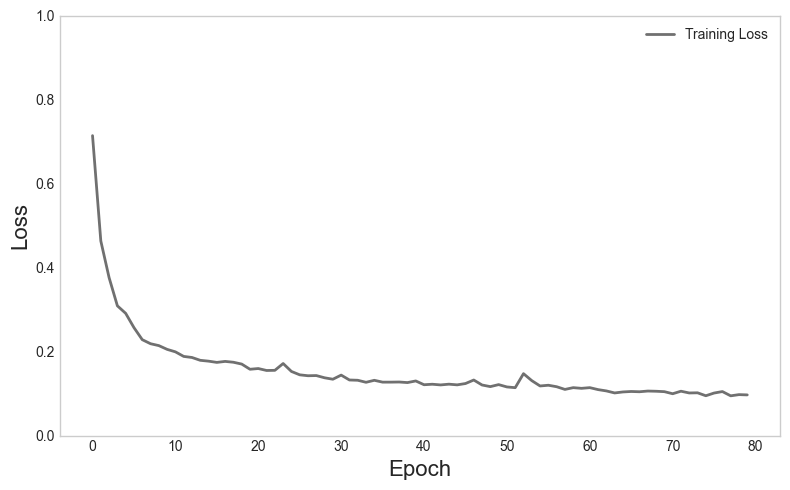

In [16]:
# Yevár la línea de desaparesimiento
losses = np.load("modelo_fi_total/training_loss.npy")

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Training Loss", color="#707070", linewidth=2)
plt.xlabel("Epoch", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.ylim(0, 1.0)  # Asentar kon números verdaderos
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.savefig("figures/training_loss_plot.png", dpi=300)
plt.show()

### Export model with batch size = 1 (ONNX) as a backup
As a backup we reshaped the input into a 3D tensor and export the final model to ONNX format with dynamic batch size set to 1, ensuring compatibility for real-time inference scenarios.

In [17]:
# Revisar una muestra para asigurárse de la armadura
print("Ejemplo de un elemento:", type(X_array[0]), X_array[0].shape)

# Unifikar todos los arreglos en una kaxa 3D
X_array = np.stack(X_array)  # (2232, seq_len, n_features)

# Asentár el kambio de formato
print("Nueva forma de X_array:", X_array.shape)

Ejemplo de un elemento: <class 'numpy.ndarray'> (1440, 3)
Nueva forma de X_array: (2232, 1440, 3)


In [18]:
seq_len = X_array.shape[1]
n_features = X_array.shape[2]

dummy_input = torch.randn(1, seq_len, n_features).to(device)

In [19]:
modelo_final.eval()

# krear dummy input kon batch size = 1
seq_len = X_array.shape[1]
n_features = X_array.shape[2]
dummy_input = torch.randn(1, seq_len, n_features).to(device)

# ONNX
torch.onnx.export(
    modelo_final, dummy_input,
    "modelo_fi_total/onnx_model_batch1.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11
)

print("✅ Modelo exportado a 'modelo_fi_total/onnx_model_batch1.onnx'")

✅ Modelo exportado a 'modelo_fi_total/onnx_model_batch1.onnx'


G:\Thesis\.venv\lib\site-packages\torch\onnx\symbolic_opset9.py:4244: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [20]:
print(type(X_array))
print(X_array.shape if hasattr(X_array, 'shape') else "No tiene atributo shape")

<class 'numpy.ndarray'>
(2232, 1440, 3)
